# Labolatorium 8

## Page Rank

---
### Przydatne importy

In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

W rozwiązaniu zadania będę wspomagał się bibliotekami zewnętrznymi:
 * `numpy` w wersji *1.18.4* - szybkie obliczenia i funkcje pomocnicze - [docs](https://docs.scipy.org/doc/numpy/)
 * `networkx` w wersji *2.4* - struktury i operacje na grafach - [docs](https://networkx.github.io/documentation/stable/)
 * `matplotlib` w wersji *3.2.1* - wizualizacja wyników i progresu - [docs](https://matplotlib.org/#documentation)

---
### Zadanie 1 Prosty ranking wierzchołków

Zaimplementuj prosty model błądzenia przypadkowego po grafie skierowanym:
<h3><div align="center">$r(u) = d \sum_{v \in B_u} \frac{r(v)}{N_v}$, </div></h3>
gdzie $r(u)$ oznacza ranking wierzchołka $u$, parametr $c$ (chyba powinno być $d$?) jest używany w normalizacji, $B_u$ jest zbiorem wierzchołków, do których dochodzą krawędzie z wierzchołka $v$, $F_v$ oznacza zbiór wierzchołków, do których dochodzą krawędzie z wierzchołka $v$, a $N_v = |F_v|$. W zapisie macierzowym:
<h3><div align="center">$ r = dAr, $ </div></h3>
gdzie $A$ jest macierzą adjacencji grafu, w której każdy wierzu $u$ jest przeskalowany wyjściowym stopniem wierzchołka $u$.


<h3><div align="center">$A_{u,v} = \begin{cases} \frac{1}{N_u} &\text{jeśli krawędź $(u,v)$ istnieje} \\ 0             &\text{w przeciwnym wypadku} \end{cases} $</div></h3>


Zauważ, że **r** może zostać obliczony jako dominujący wektor własny macierzy **A** za pomocą metody potęgowej (dominujący wektor własny $q_1$ znormalizowany za pomocą normy $L1$). Przetestuj poprawność obliczen korzystając z 3 dowolnych silnie spójnych grafów skierowanych o liczbie wierzchołków większej niż 10.

W pierwszej kolejności stworzymy sobie generator grafów skierowanych:

In [8]:
def generate_strongly_connected_graph(n=10, edge_probability=0.5):
    G = nx.gnp_random_graph(n, edge_probability, directed=True)
    while not nx.is_strongly_connected(G):
        G = nx.gnp_random_graph(n, edge_probability, directed=True)
    return G

Wygenerujmy trzy grafy *G_1, G_2, G_3* o liczbie wierzchołków odpowiednio *15, 20, 30* i sprawdźmy czy zostały one wygenerowane poprawnie:

In [10]:
G_1 = generate_strongly_connected_graph(15)
G_2 = generate_strongly_connected_graph(20)
G_3 = generate_strongly_connected_graph(30)

In [14]:
print(list(nx.strongly_connected_components(G_1)))
print(list(nx.strongly_connected_components(G_2)))
print(list(nx.strongly_connected_components(G_3)))

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}]
[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}]
[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}]


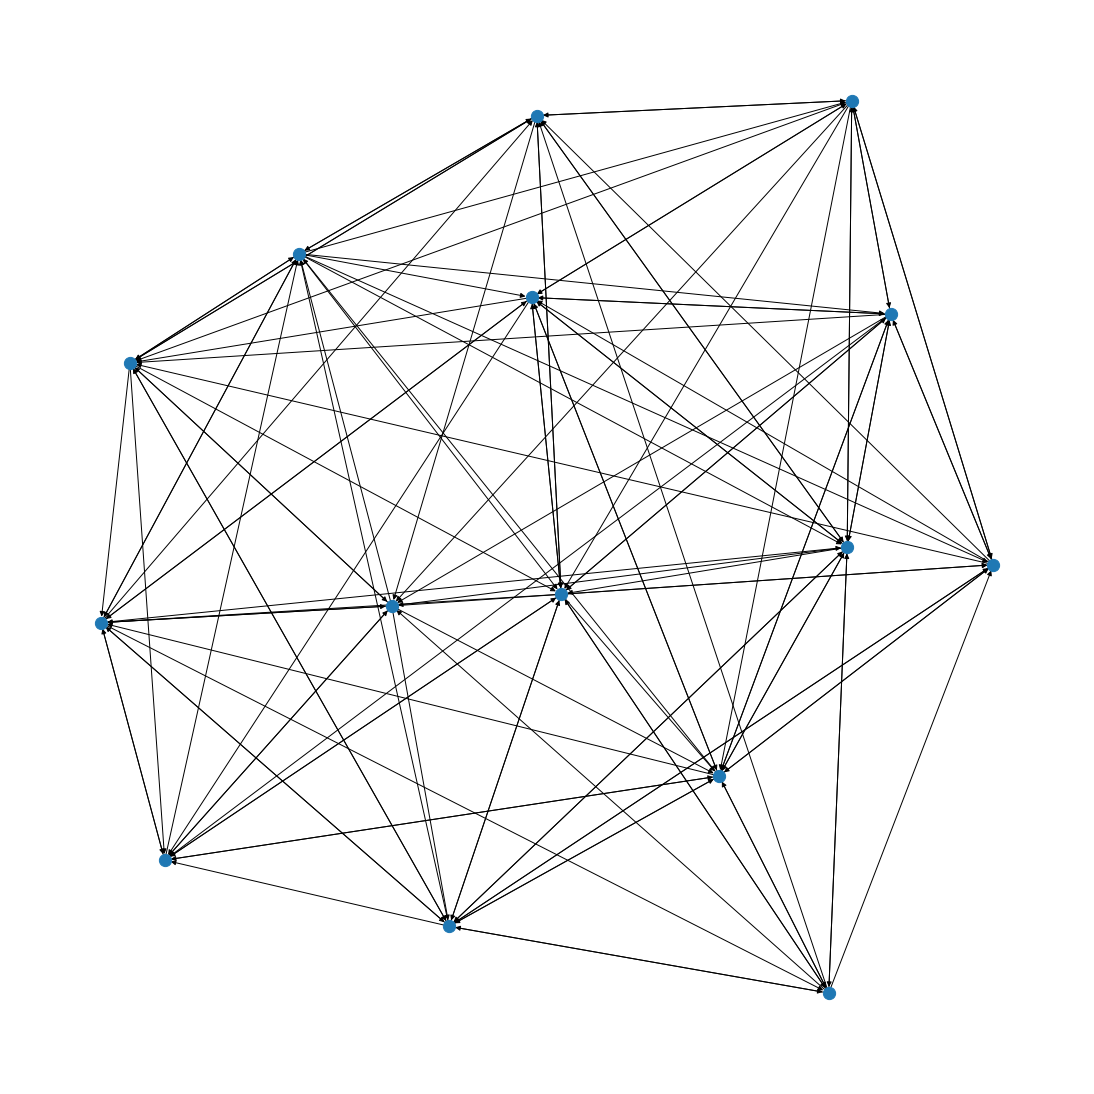

In [20]:
plt.figure(1, figsize=(15, 15))
position = nx.kamada_kawai_layout(G_1)
nx.draw(G_1, position, node_size=150)

Mając już wygenerowane grafy testowe, możemy przystąpić do rozwiązywania zadania. Postaram się skorzystać macierzowej funkcji **r**:
<h3><div align="center">$ r = dAr, $ </div></h3>
gdzie $A$ jest macierzą adjacencji grafu, w której każdy wierzu $u$ jest przeskalowany wyjściowym stopniem wierzchołka $u$.


<h3><div align="center">$A_{u,v} = \begin{cases} \frac{1}{N_u} &\text{jeśli krawędź $(u,v)$ istnieje} \\ 0             &\text{w przeciwnym wypadku} \end{cases} $</div></h3>

Zacznę od funkcji która przyjmuje graph i zwraca dla niego macierz $A$.

In [80]:
def get_scaled_adjacency_matrix(G):
    A = nx.to_numpy_matrix(G)
    scaled_A = A / np.sum(A, axis=1)
    return(scaled_A)

In [81]:
get_scaled_adjacency_matrix(G_1)

matrix([[0.        , 0.        , 0.        , 0.14285714, 0.        ,
         0.        , 0.14285714, 0.14285714, 0.14285714, 0.        ,
         0.14285714, 0.        , 0.        , 0.14285714, 0.14285714],
        [0.14285714, 0.        , 0.14285714, 0.14285714, 0.        ,
         0.        , 0.        , 0.14285714, 0.        , 0.        ,
         0.14285714, 0.14285714, 0.14285714, 0.        , 0.        ],
        [0.        , 0.11111111, 0.        , 0.11111111, 0.        ,
         0.        , 0.11111111, 0.11111111, 0.11111111, 0.        ,
         0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.        ],
        [0.        , 0.        , 0.16666667, 0.        , 0.16666667,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.16666667, 0.16666667, 0.16666667, 0.16666667],
        [0.11111111, 0.        , 0.11111111, 0.11111111, 0.        ,
         0.        , 0.11111111, 0.        , 0.11111111, 0.11111111,
         0.        , 0.       

Następnie postaram się stworzyć funkcję, na wejściu przyjmuje macierz **A** i metodą potęgową oblicza jej wektor własny znormalizowany za pomocą normy *L1*. Wspomogę się własną implementacją z poprzedniego labolatorium.

In [100]:
def power_method(matrix, max_iterations=100000,  eps=10**(-12)):
    n = matrix.shape[0]
    x = np.random.uniform(size=(n, 1))

    for k in range(max_iterations):
        y = matrix @ x
        y /= np.linalg.norm(y, ord=1)
        
        if np.linalg.norm(x - y, ord=1) < eps:
            x = y
            break

        x = y
    
    return x

Wreszcie stworzę funkcję, która przyjmuje graf i korzystając z obu powyższych funkcji, zwraca wektor **r**:

In [101]:
def get_simple_rank(graph):
    A = get_scaled_adjacency_matrix(graph)
    return power_method(A)

In [102]:
r_1 = get_simple_rank(G_1)
r_2 = get_simple_rank(G_2)
r_3 = get_simple_rank(G_3)

Sprawdźmy czy obliczenia zostały wykonane poprawnie

In [104]:
print(np.linalg.norm(r_1, ord=1))
print(np.linalg.norm(r_2, ord=1))
print(np.linalg.norm(r_3, ord=1))

1.0000000000000002
1.0
1.0000000000000002


Jak widać $||r||_1 = 1$ zatem można założyć, że obliczenia dla tych trzech grafów zostały wykonane poprawnie.

---
### Zadanie 3 Page Rank

Rozszerz model z poprzedniego zadania, dodając możliwość skoku do losowego wierzchołka grafu:
<h3><div align="center">$r(u) = d \sum_{v \in B_u} \frac{r(v)}{N_v} + (1 - d)\cdot e(u)$, </div></h3>

W zapisie macierzowym:
<h3><div align="center">$ r = dAr + (1 - d)e\otimes 1, $ </div></h3>
gdzie $||r||_1 = 1$, a $e$ jest wektorem zawierającym prawdopodobieństwo odwiedzania wierzchołków przez losowy skok. Wykorzystaj metodę potęgową do obliczenia Page Rank jako dominującego wektora własnego macierz $B = dA + (1-d)e\otimes 1$.

Najpierw przygotujmy sobie dane testowe. Skorzystamy z grafów *G_1, G_2, G_3* z poprzedniego podpunktu.

In [118]:
D = np.array([0.9, 0.85, 0.75, 0.6, 0.5])

def get_E(G):
    n = len(G)
    e_1 = np.ones(shape=n)/n
    e_2 = np.random.uniform(size=n)
    e_2 = e_2/np.sum(e_2)
    e_3 = np.ones(shape=n)/(2*n)
    e_3[0] += 0.5
    return np.array([e_1, e_2, e_3])

E_1 = get_E(G_1)
E_2 = get_E(G_2)
E_3 = get_E(G_3)

In [119]:
print(E_1[0])
print(E_1[1])
print(E_1[2])

[0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667]
[0.00386238 0.06786368 0.13799882 0.05431735 0.10690275 0.00431494
 0.05451858 0.11075357 0.09734749 0.12061735 0.05458916 0.03092283
 0.06884427 0.05140326 0.03574356]
[0.53333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333]


Teraz zmodyfikuję metodę potęgową, zgodnie z zaleconym algorytmem tak, aby uwzględniała możliwość skoku do losowego wierzchołka grafu.